# Report

Let's set the random seeds for reproducibility.

In [1]:
import numpy as np
import random
import torch
import lightning as L

RANDOM_SEED = 42
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
torch.cuda.manual_seed_all(RANDOM_SEED)
L.seed_everything(RANDOM_SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False


Seed set to 42


## Data Preprocessing

We will start by loading the data for the Apple stock and inspecting their first few rows.

In [2]:
import yfinance as yf

# Download Apple stock data
stock_prices = yf.download('AAPL', 
                   start='2015-01-01', 
                   end='2024-01-31')

# Display the first few rows
print("First few rows of Apple stock data:")
stock_prices.head()

[*********************100%***********************]  1 of 1 completed

First few rows of Apple stock data:


Price,Adj Close,Close,High,Low,Open,Volume
Ticker,AAPL,AAPL,AAPL,AAPL,AAPL,AAPL
Date,,,,,,
2015-01-02 00:00:00+00:00,24.373955,27.332500,27.860001,26.837500,27.847500,212818400
2015-01-05 00:00:00+00:00,23.687304,26.562500,27.162500,26.352501,27.072500,257142000
2015-01-06 00:00:00+00:00,23.689529,26.565001,26.857500,26.157499,26.635000,263188400
2015-01-07 00:00:00+00:00,24.021709,26.937500,27.049999,26.674999,26.799999,160423600
2015-01-08 00:00:00+00:00,24.944679,27.972500,28.037500,27.174999,27.307501,237458000


Let's examine the path of the stock's closing price over time.

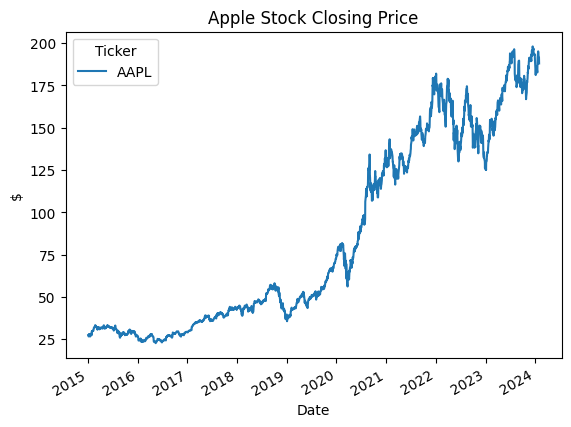

In [3]:
import matplotlib.pyplot as plt

stock_prices['Close'].plot()
plt.title('Apple Stock Closing Price')
plt.xlabel('Date')
plt.ylabel('$')
plt.show()



The stock price has a clear upward (multiplicative) trend over time as expected from such a tech company. There is a dip in early 2019 and 2020 probably due to the COVID-19 pandemic, which is followed by a significant growh rate. The volatility seems to be increasing as the price is increasing.

Let's check for any missing values in the dataset.


In [4]:
# Check for missing values in the dataset
stock_prices.isnull().sum()

Price      Ticker
Adj Close  AAPL      0
Close      AAPL      0
High       AAPL      0
Low        AAPL      0
Open       AAPL      0
Volume     AAPL      0
dtype: int64

There are none.

We proceed with the calculation of the daily returns. We expect to have only one missing value in the daily returns due to the nature of the calculation.

We then define the extreme events, which will act as our target variable.

In [5]:
# Calculate the daily returns
stock_prices['Daily_Returns'] = stock_prices['Adj Close'].pct_change() * 100

# Remove the first row as it is a NaN value
stock_prices = stock_prices.dropna()
stock_prices.head()


Price,Adj Close,Close,High,Low,Open,Volume,Daily_Returns
Ticker,AAPL,AAPL,AAPL,AAPL,AAPL,AAPL,
Date,,,,,,,
2015-01-05 00:00:00+00:00,23.687304,26.562500,27.162500,26.352501,27.072500,257142000,-2.817151
2015-01-06 00:00:00+00:00,23.689529,26.565001,26.857500,26.157499,26.635000,263188400,0.009397
2015-01-07 00:00:00+00:00,24.021709,26.937500,27.049999,26.674999,26.799999,160423600,1.402223
2015-01-08 00:00:00+00:00,24.944679,27.972500,28.037500,27.174999,27.307501,237458000,3.842232
2015-01-09 00:00:00+00:00,24.971437,28.002501,28.312500,27.552500,28.167500,214798000,0.107270


In [6]:
# Create the Extreme_Event column
stock_prices['Extreme_Event'] = (abs(stock_prices['Daily_Returns']) > 2).astype(int)
stock_prices.head()


Price,Adj Close,Close,High,Low,Open,Volume,Daily_Returns,Extreme_Event
Ticker,AAPL,AAPL,AAPL,AAPL,AAPL,AAPL,,
Date,,,,,,,,
2015-01-05 00:00:00+00:00,23.687304,26.562500,27.162500,26.352501,27.072500,257142000,-2.817151,1
2015-01-06 00:00:00+00:00,23.689529,26.565001,26.857500,26.157499,26.635000,263188400,0.009397,0
2015-01-07 00:00:00+00:00,24.021709,26.937500,27.049999,26.674999,26.799999,160423600,1.402223,0
2015-01-08 00:00:00+00:00,24.944679,27.972500,28.037500,27.174999,27.307501,237458000,3.842232,1
2015-01-09 00:00:00+00:00,24.971437,28.002501,28.312500,27.552500,28.167500,214798000,0.107270,0


We expect that the dataset will be imbalanced. Let's verify that.

In [7]:
# Count the number of extreme events
extreme_events = stock_prices[stock_prices['Extreme_Event'] == 1]
print(f"Number of extreme events: {len(extreme_events)}")

# Print the percentage of extreme events and no extreme events in the dataset
print(f"Percentage of extreme events: {len(extreme_events) / len(stock_prices) * 100:.2f}%")
print(f"Percentage of no extreme events: {(len(stock_prices) - len(extreme_events)) / len(stock_prices) * 100:.2f}%")



Number of extreme events: 460
Percentage of extreme events: 20.15%
Percentage of no extreme events: 79.85%


**The dataset is moderately imbalanced with approximately 20% of the data being extreme events. This is a challenge that we will have to address in the modelling phase.**

Our choices for doing so are limited, since we are dealing with a time-series dataset and we need to preserve the temporal nature of the data, which excludes the traditional use of resampling techniques, such as upsampling the minority class or undersampling the majority class. 

Nevertheless, we will mitigate this issue by using weighted loss functions for the neural networks and balanced class weights for the random forest.

Next, we shift the target variable `Extreme_Event` by one day so that the model is trained to predict if an extreme event occurs **tomorrow** based on today's data.

In [8]:
# Shift the Extreme_Event column by one day
stock_prices['Extreme_Event'] = stock_prices['Extreme_Event'].shift(-1)

# Remove the last row as it is a NaN value
stock_prices = stock_prices.dropna()
stock_prices['Extreme_Event'] = stock_prices['Extreme_Event'].astype(int)
stock_prices.head()

Price,Adj Close,Close,High,Low,Open,Volume,Daily_Returns,Extreme_Event
Ticker,AAPL,AAPL,AAPL,AAPL,AAPL,AAPL,,
Date,,,,,,,,
2015-01-05 00:00:00+00:00,23.687304,26.562500,27.162500,26.352501,27.072500,257142000,-2.817151,0
2015-01-06 00:00:00+00:00,23.689529,26.565001,26.857500,26.157499,26.635000,263188400,0.009397,0
2015-01-07 00:00:00+00:00,24.021709,26.937500,27.049999,26.674999,26.799999,160423600,1.402223,1
2015-01-08 00:00:00+00:00,24.944679,27.972500,28.037500,27.174999,27.307501,237458000,3.842232,0
2015-01-09 00:00:00+00:00,24.971437,28.002501,28.312500,27.552500,28.167500,214798000,0.107270,1


We continue by splitting the data into training, validation and test sets.


In [9]:
# Extract features and labels
features = stock_prices[['Open', 'High', 'Low', 'Close', 'Volume', 'Daily_Returns']]
labels = stock_prices['Extreme_Event'].astype(int)  # Target variable

# Define train/val/test split ratios
train_ratio = 0.7
val_ratio = 0.85

# Split into train, validation and test sets
train_size = int(train_ratio * len(stock_prices))
val_size = int(val_ratio * len(stock_prices))

X_train = features.iloc[:train_size]
y_train = labels.iloc[:train_size]

X_val = features.iloc[train_size:val_size]
y_val = labels.iloc[train_size:val_size]

X_test = features.iloc[val_size:]
y_test = labels.iloc[val_size:]

print(f"Training features shape: {X_train.shape}, labels shape: {y_train.shape}")
print(f"Validation features shape: {X_val.shape}, labels shape: {y_val.shape}")
print(f"Test features shape: {X_test.shape}, labels shape: {y_test.shape}")

Training features shape: (1597, 6), labels shape: (1597,)
Validation features shape: (342, 6), labels shape: (342,)
Test features shape: (343, 6), labels shape: (343,)


Let's check the distribution of labels in the training, validation and test sets. We want to avoid overestimating the performance of the model on unseen data, due to total lack of positive examples.

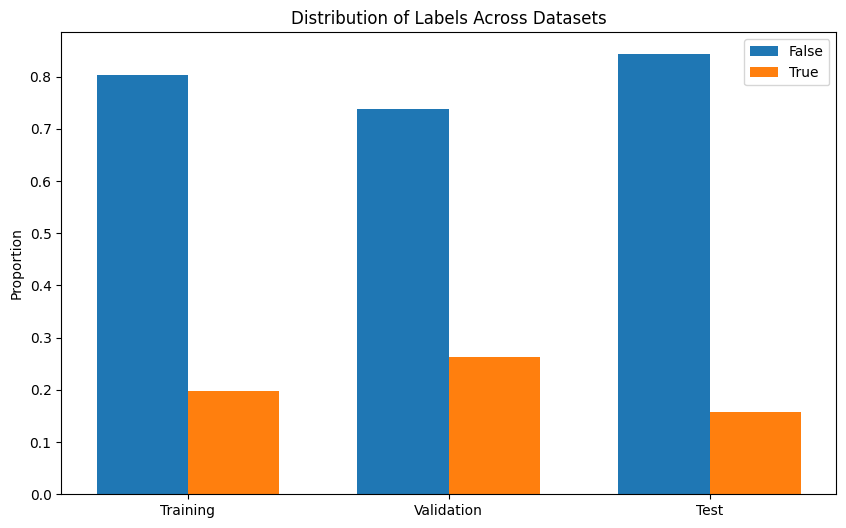

In [10]:
import matplotlib.pyplot as plt
import numpy as np

# Calculate distributions
train_dist = y_train.value_counts() / len(y_train)
val_dist = y_val.value_counts() / len(y_val)
test_dist = y_test.value_counts() / len(y_test)

# Create bar plot
fig, ax = plt.subplots(figsize=(10, 6))

x = np.arange(3)
width = 0.35

# Group bars by False/True
false_vals = [train_dist[0], val_dist[0], test_dist[0]]
true_vals = [train_dist[1], val_dist[1], test_dist[1]]

ax.bar(x - width/2, false_vals, width, label='False')
ax.bar(x + width/2, true_vals, width, label='True')

ax.set_xticks(x)
ax.set_xticklabels(['Training', 'Validation', 'Test'])
ax.set_ylabel('Proportion')
ax.set_title('Distribution of Labels Across Datasets')
ax.legend()

plt.show()


The distribution of labels is similar across the datasets, so we can procced with fitting the models.

As a final step of preprocessing, we will transform the data into a more appropriate format for supervised learning. Specifically, for each day, we will create a sequence of historical features by going back 10 days. Hence, since  the dataset has 6 features, we will end up with 60 features for each day. The corresponding label will be 1 if an extreme event occurs tomorrow and 0 otherwise.

In [11]:
from data_preprocessing import StockDataPreprocessor

X_train, y_train = StockDataPreprocessor.time_series_to_supervised(
        X_train, y_train, lookback=10
    )
X_val, y_val = StockDataPreprocessor.time_series_to_supervised(X_val, y_val, lookback=10)
X_test, y_test = StockDataPreprocessor.time_series_to_supervised(X_test, y_test, lookback=10)

print(f"Training features shape: {X_train.shape}, labels shape: {y_train.shape}")
print(f"Validation features shape: {X_val.shape}, labels shape: {y_val.shape}")
print(f"Test features shape: {X_test.shape}, labels shape: {y_test.shape}")


Training features shape: (1587, 60), labels shape: (1587,)
Validation features shape: (332, 60), labels shape: (332,)
Test features shape: (333, 60), labels shape: (333,)


Note: All the above steps are implemented in the `src/data_preprocessing.py` file.

Let's examine the first few rows of the training set. For each feature, we will have 10 days of history, amounting to 60 featurs in total.

In [12]:
print(f'Shape of the training set: {X_train.shape}')
X_train.head()


Shape of the training set: (1587, 60)


,Open(t-10),High(t-10),Low(t-10),Close(t-10),Volume(t-10),Daily_Returns(t-10),Open(t-9),High(t-9),Low(t-9),Close(t-9),...,Low(t-2),Close(t-2),Volume(t-2),Daily_Returns(t-2),Open(t-1),High(t-1),Low(t-1),Close(t-1),Volume(t-1),Daily_Returns(t-1)
Date,,,,,,,,,,,,,,,,,,,,,
2015-01-20 00:00:00+00:00,27.072500,27.162500,26.352501,26.562500,257142000.0,-2.817151,26.635000,26.857500,26.157499,26.565001,...,26.665001,26.705000,240056000.0,-2.714021,26.757500,26.895000,26.299999,26.497499,314053200.0,-0.777047
2015-01-21 00:00:00+00:00,26.635000,26.857500,26.157499,26.565001,263188400.0,0.009397,26.799999,27.049999,26.674999,26.937500,...,26.299999,26.497499,314053200.0,-0.777047,26.959999,27.242500,26.625000,27.180000,199599600.0,2.575728
2015-01-22 00:00:00+00:00,26.799999,27.049999,26.674999,26.937500,160423600.0,1.402223,27.307501,28.037500,27.174999,27.972500,...,26.625000,27.180000,199599600.0,2.575728,27.237499,27.764999,27.067499,27.387501,194303600.0,0.763436
2015-01-23 00:00:00+00:00,27.307501,28.037500,27.174999,27.972500,237458000.0,3.842232,28.167500,28.312500,27.552500,28.002501,...,27.067499,27.387501,194303600.0,0.763436,27.565001,28.117500,27.430000,28.100000,215185600.0,2.601532
2015-01-26 00:00:00+00:00,28.167500,28.312500,27.552500,28.002501,214798000.0,0.107270,28.150000,28.157499,27.200001,27.312500,...,27.430000,28.100000,215185600.0,2.601532,28.075001,28.437500,27.882500,28.245001,185859200.0,0.516030


# Random Forest Model

We now proceed with fitting the random forest model. Since we are using a tree-based model, we will not normalize the data.

In order to tune the hyperparameters of the random forest model, we will use the `hyperopt` library. It uses a Bayesian optimization approach to find the best hyperparameters, called `Tree of Parzen Estimators` (TPE).  This method models the likelihood of the objective function, given the data and a choice of hyperparameters, using kernel density estimation.

The choice of metric for the optimization is nuanced when dealing with imbalanced datasets and one should consider what is the cost of the false negatives and false positives. In our case, a false positive would mean that we inaccurately predict an extreme event for the next day, which could lead to a loss of capital and trust in the model. On the other hand, a false negative would mean that we inaccurately predict no extreme event for the next day, which could lead to a loss of potential profits. 

Precision is preffered when false positives are more costly and recall is preffered when false negatives are more costly. Assuming that we are not highly risk averse, i.e. we are willing to lose some money in order to make a profit, we will use the metric $F_{\beta}$ with $\beta = 2$ as our optimization metric, which weighs recall more heavily than precision.

$F_{2}$ is defined as:

$F_{2} = (1 + 2^2) \cdot \frac{\operatorname{Precision} \cdot \operatorname{Recall}}{2^2 \cdot \operatorname{Precision} + \operatorname{Recall}}$,

where $\operatorname{Precision} = \frac{TP}{TP + FP}$ and $\operatorname{Recall} = \frac{TP}{TP + FN}$.



In [13]:
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import fbeta_score

def objective(params):
    """
    Objective function for hyperopt optimization.
    """
    model_params = {
        'n_estimators': int(params['n_estimators']),
        'max_depth': int(params['max_depth']),
        'min_samples_split': int(params['min_samples_split']),
        'min_samples_leaf': int(params['min_samples_leaf']),
        'max_leaf_nodes': int(params['max_leaf_nodes']),
        'max_features': params['max_features'],
        'min_impurity_decrease': params['min_impurity_decrease'],
        'criterion': 'entropy',  
        'class_weight': 'balanced',
        'bootstrap': True,
        'random_state': 42,
        'n_jobs': -1
    }
    
    # Create and train model
    model = RandomForestClassifier(**model_params)
    model.fit(X_train.values, y_train.values.astype(int))
    
    # Evaluate on validation set
    y_pred = model.predict(X_val.values)
    f2 = fbeta_score(y_val.values.astype(int), y_pred, beta=2)
    
    return {'loss': -f2, 'status': STATUS_OK}

# Define search space
space = {
    'n_estimators': hp.quniform('n_estimators', 700, 800, 1),
    'max_depth': hp.quniform('max_depth', 70, 100, 1),
    'min_samples_split': hp.quniform('min_samples_split', 5, 15, 1),
    'min_samples_leaf': hp.quniform('min_samples_leaf', 1, 3, 1),
    'max_features': hp.uniform('max_features', 0.8, 1.0),
    'max_leaf_nodes': hp.quniform('max_leaf_nodes', 500, 600, 1),
    'min_impurity_decrease': hp.uniform('min_impurity_decrease', 0.04, 0.05),
}

# Run optimization
trials = Trials()
best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=30,
            trials=trials)

print("\nBest trial:")
print(f"  Value (F2): {-min(trials.losses()):.4f}")
print("\nBest parameters:")
for key, value in best.items():
    print(f"    {key}: {value}")

100%|██████████| 30/30 [00:34<00:00,  1.16s/trial, best loss: -0.6432748538011696]

Best trial:
  Value (F2): 0.6433

Best parameters:
    max_depth: 96.0
    max_features: 0.8098582865554091
    max_leaf_nodes: 599.0
    min_impurity_decrease: 0.04380604831017937
    min_samples_leaf: 2.0
    min_samples_split: 12.0
    n_estimators: 722.0


We proceed with fitting the final model with the best parameters and evaluating on the test set.

In [14]:
# Train final model with best parameters
best_params = best.copy()
best_params['n_estimators'] = int(best_params['n_estimators'])
best_params['max_depth'] = int(best_params['max_depth'])
best_params['min_samples_split'] = int(best_params['min_samples_split'])
best_params['min_samples_leaf'] = int(best_params['min_samples_leaf'])
best_params['max_leaf_nodes'] = int(best_params['max_leaf_nodes'])

best_params.update({
    'criterion': 'entropy',
    'class_weight': 'balanced',
    'bootstrap': True,
    'random_state': 42,
    'n_jobs': -1
})

final_model = RandomForestClassifier(**best_params)
final_model.fit(X_train.values, y_train.values.astype(int))

RandomForestClassifier(class_weight='balanced', criterion='entropy',
                       max_depth=96,
                       max_features=np.float64(0.8098582865554091),
                       max_leaf_nodes=599,
                       min_impurity_decrease=np.float64(0.04380604831017937),
                       min_samples_leaf=2, min_samples_split=12,
                       n_estimators=722, n_jobs=-1, random_state=42)

Test Set Metrics:
----------------------------------------
F2 Score            : 0.4690
F1 Score            : 0.2611
Precision           : 0.1502
Recall              : 1.0000
Accuracy            : 0.1502
AUC                 : 0.5000
Balanced Accuracy   : 0.5000
----------------------------------------


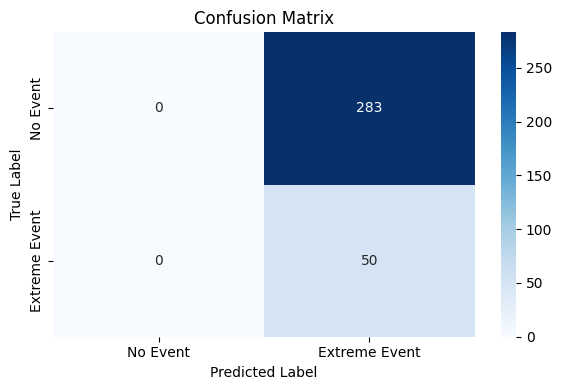

In [15]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import (accuracy_score, roc_auc_score, balanced_accuracy_score, 
                           precision_score, recall_score, confusion_matrix, f1_score)

# Make predictions
y_pred = final_model.predict(X_test.values)
y_true = y_test.values.astype(int)

# Calculate metrics
metrics = {
    'F2 Score': fbeta_score(y_true, y_pred, beta=2),
    'F1 Score': fbeta_score(y_true, y_pred, beta=1),
    'Precision': precision_score(y_true, y_pred),
    'Recall': recall_score(y_true, y_pred),
    'Accuracy': accuracy_score(y_true, y_pred),
    'AUC': roc_auc_score(y_true, y_pred),
    'Balanced Accuracy': balanced_accuracy_score(y_true, y_pred)
}

# Print metrics in a organized way
print("Test Set Metrics:")
print("-" * 40)
for metric, value in metrics.items():
    print(f"{metric:20s}: {value:.4f}")
print("-" * 40)

# Plot confusion matrix using seaborn
plt.figure(figsize=(6, 4))
cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['No Event', 'Extreme Event'],
            yticklabels=['No Event', 'Extreme Event'])
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.show()


**We see that the model is predicting all the test samples as extreme events, because of the metric we used for optimization. It has not learned how to truly distinguish the two classes, hence we are severely underfitting the training data.**


# Temporal CNN Model


Let's prepare the data for the temporal CNN model. Firstly, we will reload the data and then standardize the features, since we will be using a neural network. The daily returns do not need to be standardized due to their scale. For this purpose, we will use the `StockDataPreprocessor` class defined in the `src/data_preprocessing.py` file.

In [22]:
from data_preprocessing import StockDataPreprocessor

stock_prices = StockDataPreprocessor(
        ticker="AAPL", start_date='2015-01-01', end_date='2024-01-31'
    ).download_and_prepare_stock_data()
# Standardize the features
stock_prices = StockDataPreprocessor.standardize_data(stock_prices, ['Open', 'High', 'Low', 'Close', 'Volume'])
stock_prices.head()

[*********************100%***********************]  1 of 1 completed


Price,Adj Close,Close,High,Low,Open,Volume,Daily_Returns,Extreme_Event
Ticker,AAPL,AAPL,AAPL,AAPL,AAPL,AAPL,,
Date,,,,,,,,
2015-01-05 00:00:00+00:00,23.687304,-1.031309,-1.025440,-1.030020,-1.022063,1.965753,-2.817151,0.0
2015-01-06 00:00:00+00:00,23.689529,-1.031264,-1.030777,-1.033506,-1.029804,2.054466,0.009397,0.0
2015-01-07 00:00:00+00:00,24.021709,-1.024681,-1.027408,-1.024256,-1.026884,0.546695,1.402223,1.0
2015-01-08 00:00:00+00:00,24.944679,-1.006389,-1.010130,-1.015318,-1.017906,1.676948,3.842232,0.0
2015-01-09 00:00:00+00:00,24.971437,-1.005859,-1.005318,-1.008570,-1.002691,1.344479,0.107270,1.0


We continue by splitting the data into training, validation and test sets.

In [23]:
# Split data into train, validation and test sets
X_train, y_train, X_val, y_val, X_test, y_test = StockDataPreprocessor.split_data(
    stock_prices,
    ["Open", "High", "Low", "Close", "Volume", "Daily_Returns"],
    "Extreme_Event",
    train_ratio=0.7,
    val_ratio=0.85,
)

Finally, to predict whether an extreme event will occur tomorrow, given the past 10 days, we ought to transform the data into sequences with shape `[n_samples, n_features, lookback]`, where $lookback = 10$.

In [24]:
X_train, y_train = StockDataPreprocessor.create_sequences(X_train, y_train, lookback=10)
X_val, y_val = StockDataPreprocessor.create_sequences(X_val, y_val, lookback=10)
X_test_tcnn, y_test_tcnn = StockDataPreprocessor.create_sequences(X_test, y_test, lookback=10)

print(f"Training features shape: {X_train.shape}, labels shape: {y_train.shape}")
print(f"Validation features shape: {X_val.shape}, labels shape: {y_val.shape}")
print(f"Test features shape: {X_test.shape}, labels shape: {y_test.shape}")

Training features shape: (1587, 6, 10), labels shape: (1587,)
Validation features shape: (332, 6, 10), labels shape: (332,)
Test features shape: (343, 6), labels shape: (343,)


For the defintion of the temporal CNN model and the management of the training process, we will use the `lightning` library. All the relevant code is implemented in the `src/temporal_cnn.py` file. We import the necessary functions and classes, we train the model and plot the training and validation losses.

The AdamW optimizer is chosen, which is a combination of Adam and Tikhonov regularization, to prevent overfitting. In addition, the learning rate is automatically adjusted using the ReduceLROnPlateau scheduler. Finally, the training includes early stopping and model checkpointing callbakcs.

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name | Type       | Params | Mode 
--------------------------------------------
0 | cnn  | Sequential | 131 K  | train
--------------------------------------------
131 K     Trainable params
0         Non-trainable params
131 K     Total params
0.525     Total estimated model params size (MB)
12        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

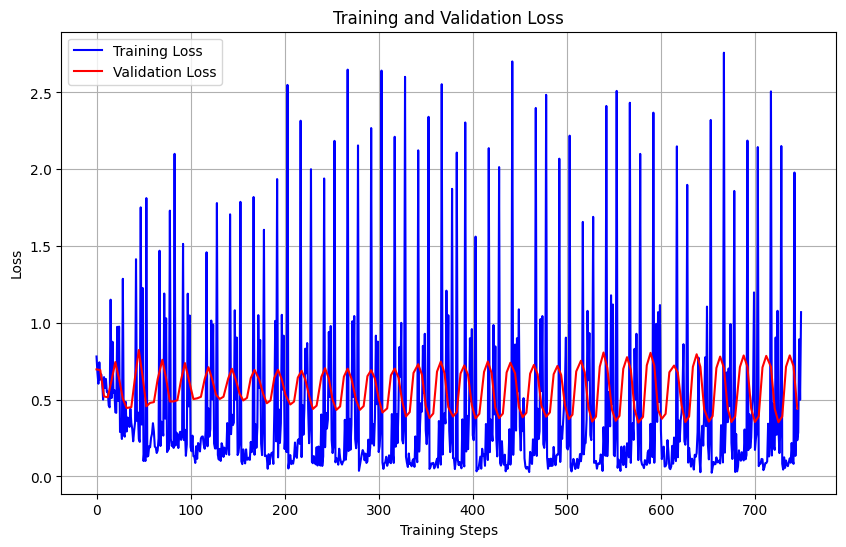

In [25]:
from temporal_cnn import TCNNClassifier

tcnn_model = TCNNClassifier(n_features=X_train.shape[1],
                            lookback=X_train.shape[2],
                            hidden_dim=64,
                            conv_channels=96,
                            kernel_size=3,
                            dropout_prob=0.3,
                            learning_rate=1e-4,
                            scheduler_patience=5,
                            scheduler_factor=0.5,
                            min_lr=1e-6)

tcnn_model.train(
        X_train, y_train, X_val, y_val, batch_size=64, max_epochs=100, patience=10
    )
tcnn_model.plot_training_history()


We see that the model is far from converged, since both losses are flactuating and not decreasing. Let's load the best model and evaluate it on the test set. 

F2 Score            : 0.1322
F1 Score            : 0.1558
Precision           : 0.2222
Recall              : 0.1200
Accuracy            : 0.8048
AUC                 : 0.5229
Balanced Accuracy   : 0.5229
----------------------------------------


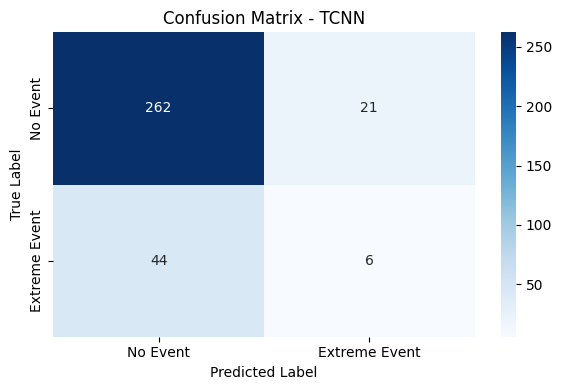

In [26]:
from temporal_cnn import TCNN
from model_evaluation import ModelEvaluator
tcnn_model = TCNN(
    n_features=X_test_tcnn.shape[1],
    lookback=10,
    hidden_dim=128,
    conv_channels=64,
    kernel_size=3,
    dropout_prob=0.3,
    learning_rate=1e-4,
)
tcnn_model.load_state_dict(torch.load("../data/models/best_tcnn.pth"))
evaluator = ModelEvaluator(model=tcnn_model, model_type="TCNN")
metrics = evaluator.evaluate(X_test_tcnn, y_test_tcnn)
for metric, value in metrics.items():
    print(f"{metric:20s}: {value:.4f}")
print("-" * 40)

evaluator.plot_confusion_matrix(X_test_tcnn, y_test_tcnn)

The TCNN seems to be better than the random forest model, since it is able to accurately predict 6 extreme events and most of the non-extreme events. Its AUC and balanced accuracy scores are 3% higher than those of the random forest model. Finally, it is predicting accurately the majority of the non-extreme events. Hence, it has slightly learned to distinguish the two classes.

Let's plot the actual and predicted extreme events over time. We will mark the actual extreme events with blue stems and the predicted extreme events with red markers.


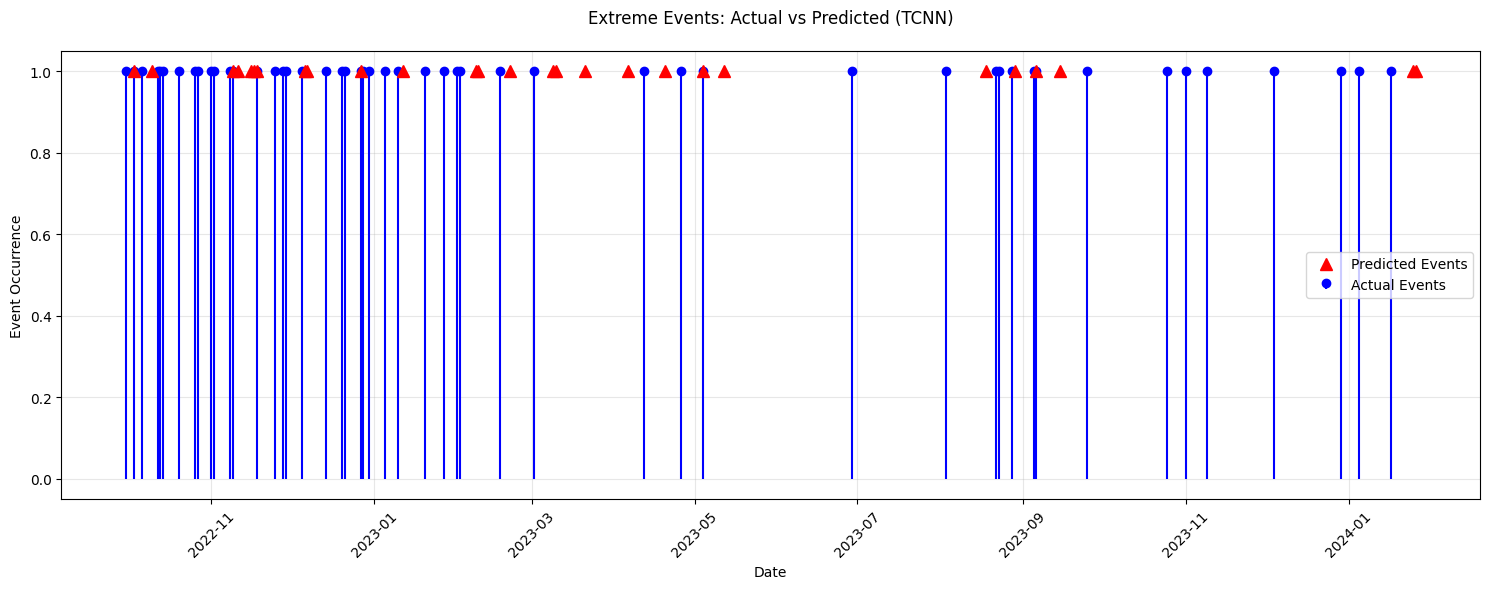

In [27]:
import matplotlib.pyplot as plt
import pandas as pd

y_test = y_test.iloc[10:]
y_pred = evaluator.predict(X_test_tcnn)
y_pred = pd.Series(y_pred, index=y_test.index)

plt.figure(figsize=(15, 6))

# Plot actual events as stems
plt.stem(y_test.index[y_test == 1], y_test[y_test == 1], 
         label='Actual Events', linefmt='b-', markerfmt='bo', basefmt=' ')

# Plot predicted events as red markers
plt.plot(y_test.index[y_pred == 1], y_pred[y_pred == 1], 
         'r^', label='Predicted Events', markersize=8)

plt.title('Extreme Events: Actual vs Predicted (TCNN)', pad=20)
plt.xlabel('Date')
plt.ylabel('Event Occurrence')

# Customize the plot
plt.grid(True, alpha=0.3)
plt.legend()

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Adjust layout to prevent label cutoff
plt.tight_layout()

# Save the plot
plt.savefig('../data/figures/tcnn_predictions.png', dpi=300, bbox_inches='tight')

The TCNN model demonstrates somewhat moderate prediction behavior, successfully identifying a few extreme events while maintaining relatively few false positives. The model's predictions show good alignment with actual events in the earlier period through March 2023, though its performance appears to decline after May 2023 where it misses most of the actual events. Still, it manages to predict a couple of exterme events after May 2023, where the true positive examples become sparser overall. It is possible that the fit of the LSTM would significantly improve, if we had a larger sample size or more balanced classes, providing a very good model for the task, since it would be to balance the precision and recall.

There are still several instances where actual events occur without corresponding predictions, suggesting room for improvement in the model's recall.

# Improvements

## Adding more features

Since we are interested in predicting extreme events, we will include five additional features that could provide useful information for the task at hand. Specifically, we will include:

-  10-day Rolling Volatility: Periods of high volatility often cluster together, and extreme events are more likely during volatile periods. 
-  Volume Relative to 10-day Moving Average: Unusual trading volume often precedes or accompanies extreme price movements.
- VIX Index: Market-wide volatility often correlates with individual stock extreme movements.
- Bollinger Band Width: Measures volatility expansion/contraction, particularly useful for identifying potential breakout periods.
- Average True Range (ATR): Captures true volatility including gaps, which is especially relevant for Apple stock around earnings periods.

The 10-day window was chosen, since we will be predicting if an extreme event occurs tomorrow based on the past 10 days of data.

In [28]:
from data_preprocessing import StockDataPreprocessor
# Insantiate the preprocessor and download the data
preprocessor = StockDataPreprocessor(ticker="AAPL", start_date="2015-01-01", end_date="2024-01-31")
stock_prices = preprocessor.download_and_prepare_stock_data()
# Add 10-day rolling volatility, volume relative to 10-day moving average and VIX index
stock_prices = preprocessor.add_features()
stock_prices.head()



[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Price,Adj Close,Close,High,Low,Open,Volume,Daily_Returns,Extreme_Event,rolling_volatility,relative_volume,VIX,bollinger_band_width,ATR
Ticker,AAPL,AAPL,AAPL,AAPL,AAPL,AAPL,,,,,,,
Date,,,,,,,,,,,,,
2015-02-27 00:00:00+00:00,28.751814,32.115002,32.642502,32.060001,32.500000,248059200,-1.502852,0.0,0.014758,1.005357,13.34,0.029195,0.59025
2015-03-02 00:00:00+00:00,28.892820,32.272499,32.570000,32.075001,32.312500,192386800,0.490426,0.0,0.014758,0.787608,13.04,0.026359,0.59900
2015-03-03 00:00:00+00:00,28.953259,32.340000,32.380001,32.022499,32.240002,151265200,0.209181,0.0,0.014685,0.646066,13.86,0.024543,0.58575
2015-03-04 00:00:00+00:00,28.769722,32.134998,32.389999,32.080002,32.275002,126665200,-0.633906,0.0,0.014717,0.553504,14.23,0.024770,0.58350
2015-03-05 00:00:00+00:00,28.292992,31.602501,32.187500,31.440001,32.145000,226068400,-1.657056,0.0,0.015625,0.955874,14.04,0.029292,0.64075


We will inspect the correlations between the features and the label. While this measure is not perfect, since it only captures linear relationships, it is still useful for indicating if the additional features are useful for the task at hand.


In [29]:
import numpy as np

correlations = stock_prices.corr()['Extreme_Event'].sort_values(ascending=False)
print("Correlations with Extreme_Event:")
print(correlations)

Correlations with Extreme_Event:
Price                 Ticker
Extreme_Event                   1.000000
VIX                             0.310769
rolling_volatility              0.256255
bollinger_band_width            0.215680
ATR                             0.213547
Volume                AAPL      0.192104
relative_volume                 0.112583
High                  AAPL      0.064290
Open                  AAPL      0.062204
Close                 AAPL      0.061895
Adj Close             AAPL      0.061462
Low                   AAPL      0.059711
Daily_Returns                  -0.055992
Name: Extreme_Event, dtype: float64


We see that the newly added features have a the highest correlation with the label, which is promising. We continue by refitting the random forest model with the new features.

The hyperparameter tuning and fitting of the model will be done in the same way as before. We will use the code defined in the module `src/random_forest.py`.

In [30]:
from random_forest import RandomForestOptimizer

# Split data into train, validation and test sets
X_train, y_train, X_val, y_val, X_test, y_test = StockDataPreprocessor.split_data(
    stock_prices,
    ["Open", "High", "Low", "Close", "Volume", "rolling_volatility", "relative_volume", "VIX", "bollinger_band_width", "ATR", "Daily_Returns"],
    "Extreme_Event",
    train_ratio=0.7,
    val_ratio=0.85,
)

X_train, y_train = StockDataPreprocessor.time_series_to_supervised(
        X_train, y_train, lookback=10
    )
X_val, y_val = StockDataPreprocessor.time_series_to_supervised(X_val, y_val, lookback=10)
X_test, y_test = StockDataPreprocessor.time_series_to_supervised(X_test, y_test, lookback=10)

# Initialize and run optimization
rf_optimizer = RandomForestOptimizer()
rf_optimizer.optimize(X_train, y_train, X_val, y_val)

# Train final model with best parameters
rf_model = rf_optimizer.train_best_model(X_train, y_train)


100%|██████████| 30/30 [01:02<00:00,  2.07s/trial, best loss: -0.6553398058252428]

Best trial:
  Value (F2): 0.6553

Best parameters:
    max_depth: 73.0
    max_features: 0.9926305625702048
    max_leaf_nodes: 575.0
    min_impurity_decrease: 0.04327828169862801
    min_samples_leaf: 3.0
    min_samples_split: 8.0
    n_estimators: 786.0


Let's evaluate the performance of the model on the test set.

F2 Score            : 0.4885
F1 Score            : 0.3285
Precision           : 0.2125
Recall              : 0.7234
Accuracy            : 0.5749
AUC                 : 0.6367
Balanced Accuracy   : 0.6367
----------------------------------------


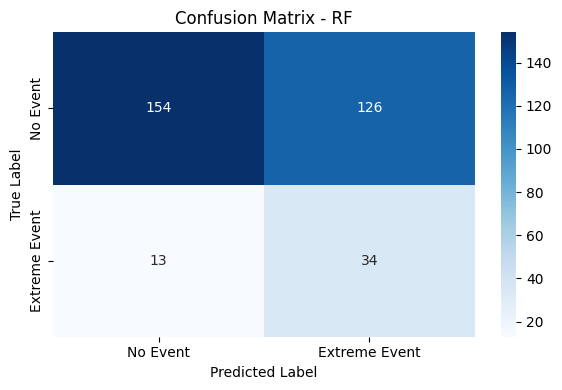

In [31]:
from model_evaluation import ModelEvaluator

rf_evaluator = ModelEvaluator(
        model=rf_model,
        model_type="RF",
    )

metrics = rf_evaluator.evaluate(X_test, y_test)
for metric, value in metrics.items():
    print(f"{metric:20s}: {value:.4f}")
print("-" * 40)

rf_evaluator.plot_confusion_matrix(X_test, y_test)
    

The model seems to be doing significantly better than the random forest and the TCNN without the additonal feautes, since it accurately predicts 34 of the 48 extreme events and 154 from the 283 non-extreme events.

The former achieves a test Area under the Receiver Operating Characteristic Curve of 0.63 approximately, while the latter yielded 0.5 and 0.52 respectively.

Let's plot the actual and predicted extreme events over time.

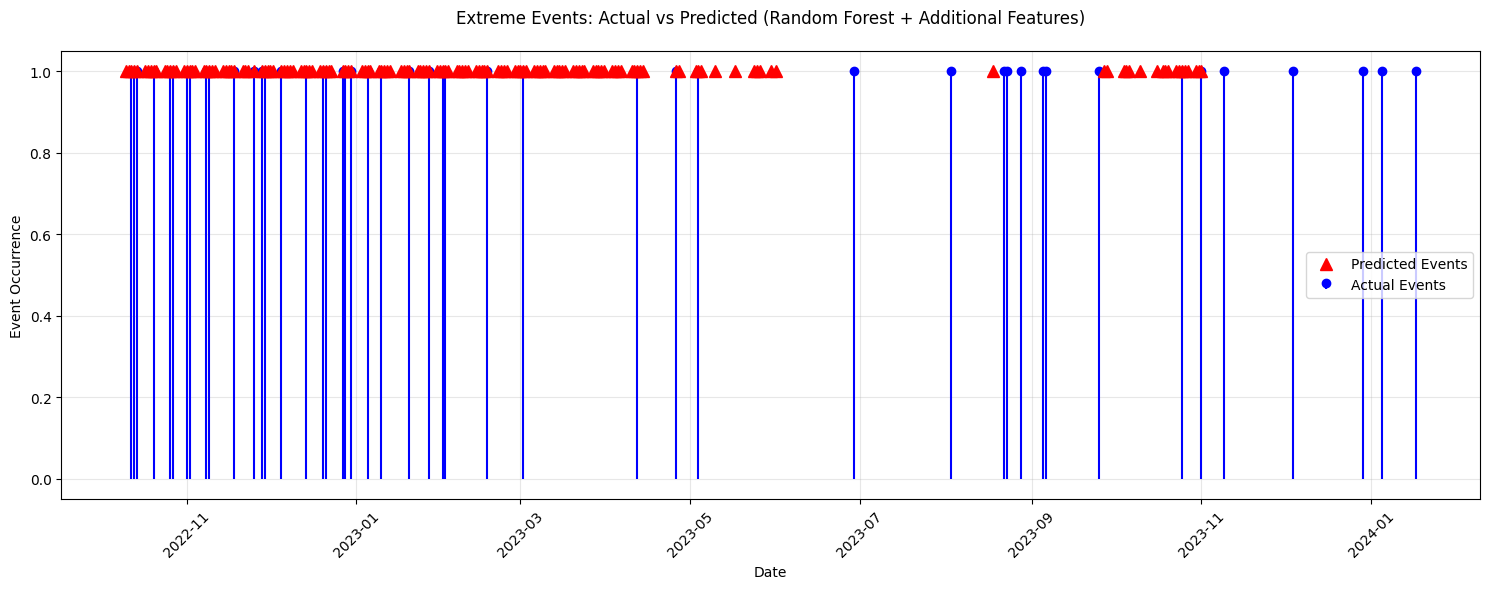

In [32]:
import matplotlib.pyplot as plt
import pandas as pd

y_pred = rf_model.predict(X_test.values)
y_pred = pd.Series(y_pred, index=y_test.index)

plt.figure(figsize=(15, 6))

# Plot actual events as stems
plt.stem(y_test.index[y_test == 1], y_test[y_test == 1], 
         label='Actual Events', linefmt='b-', markerfmt='bo', basefmt=' ')

# Plot predicted events as red markers
plt.plot(y_test.index[y_pred == 1], y_pred[y_pred == 1], 
         'r^', label='Predicted Events', markersize=8)

plt.title('Extreme Events: Actual vs Predicted (Random Forest + Additional Features)', pad=20)
plt.xlabel('Date')
plt.ylabel('Event Occurrence')

# Customize the plot
plt.grid(True, alpha=0.3)
plt.legend()

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Adjust layout to prevent label cutoff
plt.tight_layout()

# Save the plot
plt.savefig('../data/figures/rf_predictions_extra_features.png', dpi=300, bbox_inches='tight')

The model tends to overpredict extreme events, particularly in late 2022 to early 2023, exhibiting high recall but lower precision in its predictions. This aligns with our rationale of prioritizing the capture of extreme events, even at the cost of false alarms. We observe that even though the frequency of extreme events drops after May 2023, the model predicts quite a few extreme events, especially between the September and November of 2023. A next step would be to explore strategies to reduce false positives while maintaining strong recall.


## Long Short-Term Memory Model (LSTM)

We will now use a sequential neural network model. These architectures are well-suited for time series prediction tasks, since they are able to capture temporal dependencies and patterns in the data, which are inherent to time series. 

Specifically, we will fit an LSTM model, which can handle long-term dependencies in the data, which are quite useful if trends across a large range of days influence the occurrence of an extreme event. On the contrary, the convolutional neural networks are limited to capturing local temporal patterns in the data, due to the fixed window size of the convolutional operations.

We will fit an unidirectional LSTM, since we are interested in predicting the occurrence of an extreme event tomorrow, given the past 10 days and bidirectionality would violate this temporal relationship and also result into data leakage. We don't expect a good performance from the LSTM, since our sample size is not very large and the model has a significant number of parameters.



In [40]:
# Insantiate the preprocessor and download the data
from data_preprocessing import StockDataPreprocessor
preprocessor = StockDataPreprocessor(ticker="AAPL", start_date="2015-01-01", end_date="2024-01-31")
stock_prices = preprocessor.download_and_prepare_stock_data()

# Add the extra features
stock_prices = preprocessor.add_features()
# Standardize the features
stock_prices = preprocessor.standardize_data(
        stock_prices, ["Open", 
                       "High", 
                       "Low", 
                       "Close", 
                       "Volume", 
                       "rolling_volatility", 
                       "relative_volume", 
                       "VIX", 
                       "bollinger_band_width"]
    )

# Split data into train, validation and test sets
X_train_lstm, y_train_lstm, X_val_lstm, y_val_lstm, X_test_lstm, y_test_lstm = StockDataPreprocessor.split_data(
    stock_prices,
    ["Open", 
     "High", 
     "Low", 
     "Close", 
     "Volume", 
     "rolling_volatility", 
     "relative_volume", 
     "VIX", 
     "bollinger_band_width", 
     "ATR", 
     "Daily_Returns"],
    "Extreme_Event",
    train_ratio=0.7,
    val_ratio=0.85,
)
# Convert the features into sequences
X_train_lstm, y_train_lstm = preprocessor.create_sequences(X_train_lstm, y_train_lstm, lookback=10)
X_val_lstm, y_val_lstm = preprocessor.create_sequences(X_val_lstm, y_val_lstm, lookback=10)
X_test_lstm, y_test_lstm = preprocessor.create_sequences(X_test_lstm, y_test_lstm, lookback=10)

print(f"Training features shape: {X_train_lstm.shape}, labels shape: {y_train_lstm.shape}")
print(f"Validation features shape: {X_val_lstm.shape}, labels shape: {y_val_lstm.shape}")
print(f"Test features shape: {X_test_lstm.shape}, labels shape: {y_test_lstm.shape}")


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Training features shape: (1561, 11, 10), labels shape: (1561,)
Validation features shape: (327, 11, 10), labels shape: (327,)
Test features shape: (327, 11, 10), labels shape: (327,)


The LSTM layer in Pytorch expects the input data to have the shape `[samples, timesteps, features]`, so we need to permute the dimensions of the training, validation and test sets.

In [41]:
X_train_lstm = np.transpose(X_train_lstm, (0, 2, 1))  # From (samples, features, timesteps) to (samples, timesteps, features)
X_val_lstm = np.transpose(X_val_lstm, (0, 2, 1))
X_test_lstm = np.transpose(X_test_lstm, (0, 2, 1))

print(f"Training features shape: {X_train.shape}, labels shape: {y_train.shape}")
print(f"Validation features shape: {X_val.shape}, labels shape: {y_val.shape}")
print(f"Test features shape: {X_test.shape}, labels shape: {y_test.shape}")


Training features shape: (1561, 110), labels shape: (1561,)
Validation features shape: (327, 110), labels shape: (327,)
Test features shape: (327, 110), labels shape: (327,)


For the hyperparameter tuning we used `Ray Tune` package and specifically again the TPE BO algorithm. 
All this code is implemented in the `src/improvement.py` file. We load the best performing LSTM model and evaluate it on the test set.

F2 Score            : 0.2778
F1 Score            : 0.2796
Precision           : 0.2826
Recall              : 0.2766
Accuracy            : 0.7951
AUC                 : 0.5794
Balanced Accuracy   : 0.5794
----------------------------------------


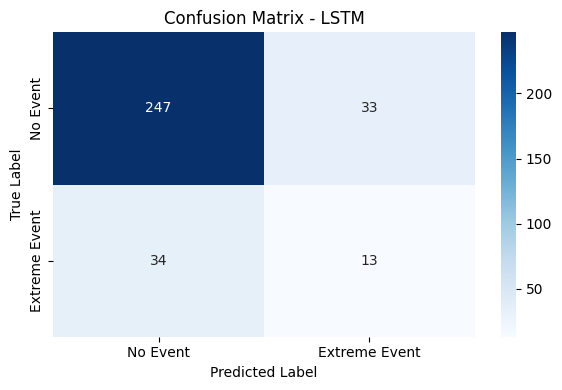

In [42]:
from improvement import LSTM

best_lstm_config = {
            "batch_size": 16,
            "dropout_prob": 0.47163297383402925,
            "hidden_dim": 128,
            "learning_rate": 0.0019016102178314065,
            "num_layers": 3,
        }
lstm_model = LSTM.load_from_checkpoint(
            "../data/models/best_lstm.ckpt",
            n_features=X_train_lstm.shape[2],
            lookback=X_train_lstm.shape[1],
            hidden_dim=best_lstm_config["hidden_dim"],
            num_layers=best_lstm_config["num_layers"],
            dropout_prob=best_lstm_config["dropout_prob"],
            learning_rate=best_lstm_config["learning_rate"],
        )

lstm_evaluator = ModelEvaluator(model=lstm_model, model_type="LSTM")
lstm_metrics = lstm_evaluator.evaluate(X_test_lstm, y_test_lstm)
for metric, value in lstm_metrics.items():
    print(f"{metric:20s}: {value:.4f}")
print("-" * 40)

lstm_evaluator.plot_confusion_matrix(X_test_lstm, y_test_lstm)


We see that the LSTM model is definetely worse than the random forest model with the additional features, with an almost 13% drop in the balanced accurac score and AUC. It is better than the TCNN, nevertheless, (57% AUC VS 52%) and thus we conclude that sequential architecture of the model was indeed beneficial.  

Let's plot the actual and predicted extreme events over time.


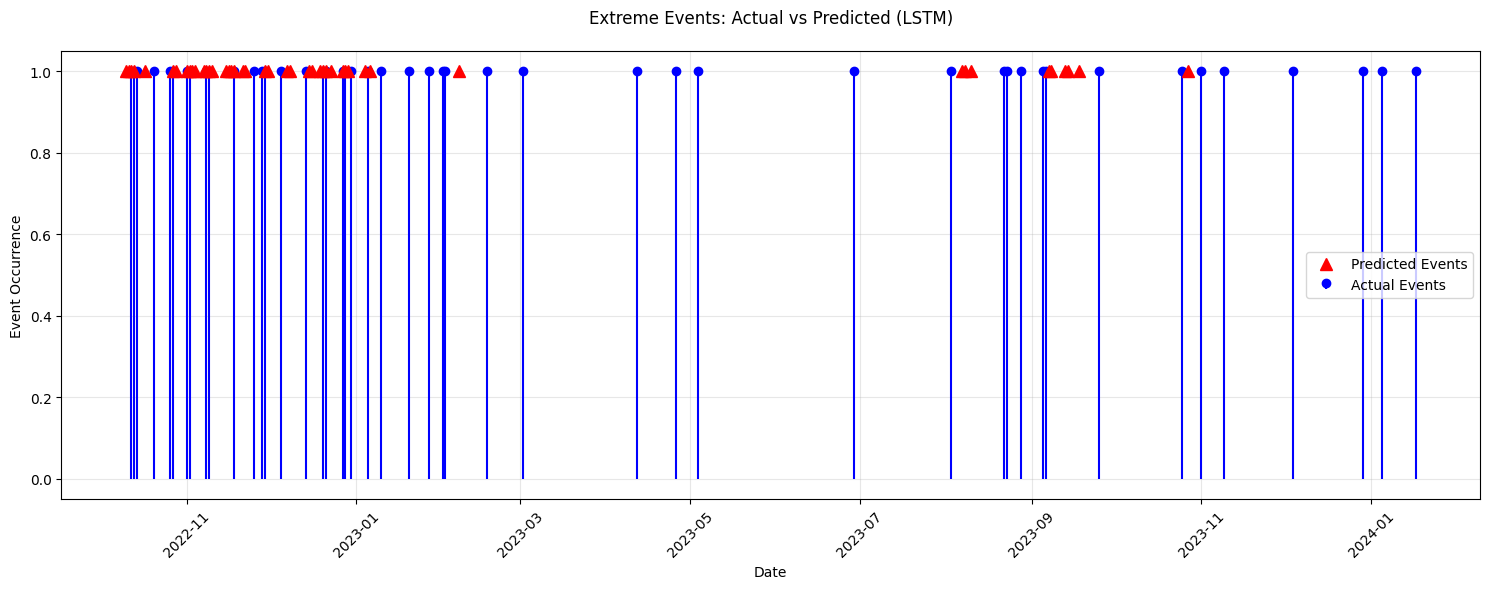

In [43]:
y_pred = lstm_evaluator.predict(X_test_lstm)
y_pred = pd.Series(y_pred, index=y_test.index)

plt.figure(figsize=(15, 6))

# Plot actual events as stems
plt.stem(y_test.index[y_test == 1], y_test[y_test == 1], 
         label='Actual Events', linefmt='b-', markerfmt='bo', basefmt=' ')

# Plot predicted events as red markers
plt.plot(y_test.index[y_pred == 1], y_pred[y_pred == 1], 
         'r^', label='Predicted Events', markersize=8)

plt.title('Extreme Events: Actual vs Predicted (LSTM)', pad=20)
plt.xlabel('Date')
plt.ylabel('Event Occurrence')

# Customize the plot
plt.grid(True, alpha=0.3)
plt.legend()

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Adjust layout to prevent label cutoff
plt.tight_layout()

# Save the plot
plt.savefig('../data/figures/lstm_predictions_extra_features.png', dpi=300, bbox_inches='tight')

The LSTM model shows a more conservative prediction behavior, correctly identifying only 13 extreme events while missing the vast majority of the rest. While the model achieves high precision with very few false positives, its low recall makes it unsuitable for our use case where we have assumed that capturing extreme events is prioritized over avoiding false alarms.

Also, after the hiatus of the extreme events, taking place after March 2023, it seems to be unable to predict accurately the occurence of extreme events, by contrast with the TCNN.

**Note: A multilayer perceptron (MLP) model was also fitted, but due to its poor performance, it is not included in the report.**

# Conclusion

## Model comparison

Let's compare the three best models: TCNN without extra features, random forest and LSTM with extra features. With respect to the classification metrics, the random forest outperforms the other two models, with the TCNN being the second best. The LSTM model is the worst performing model, with the lowest balanced accuracy and AUC scores.

But considering the task we need to consider the trade-off between precision and recall, as wel as how their predictive performance evolves over time. Let's plot the cumulative accuracy of the three models over time.


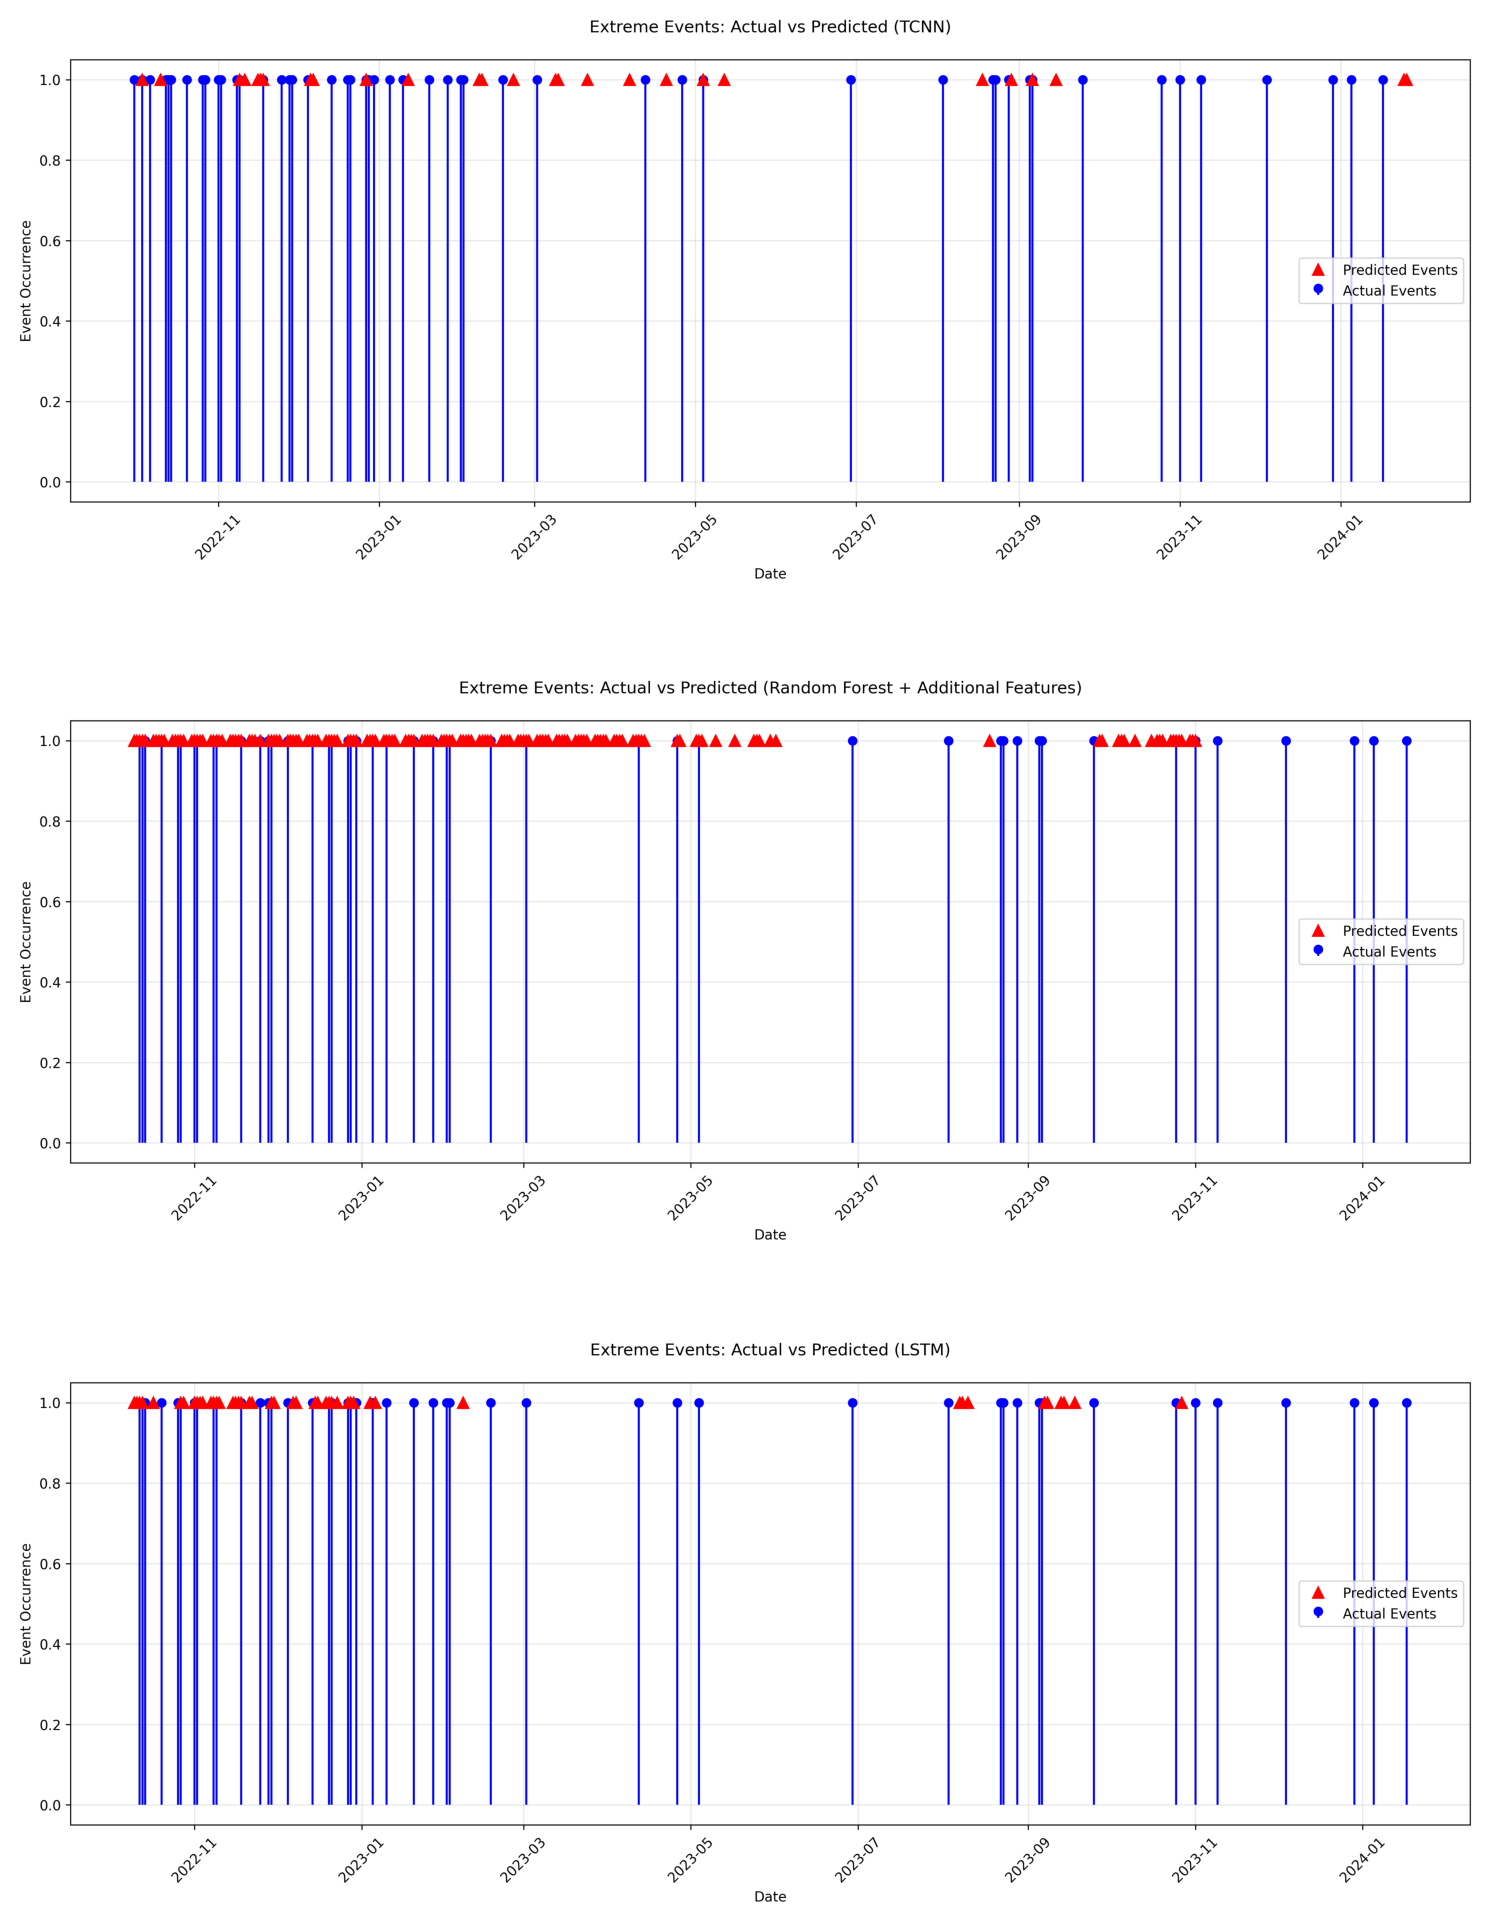

In [44]:
from PIL import Image

fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(15, 20))  # Adjusted figsize for better vertical layout

# Load and display each image
img1 = Image.open('../data/figures/tcnn_predictions.png')
img2 = Image.open('../data/figures/rf_predictions_extra_features.png')
img3 = Image.open('../data/figures/lstm_predictions_extra_features.png')

ax1.imshow(img1)
ax1.axis('off')

ax2.imshow(img2)
ax2.axis('off')

ax3.imshow(img3)
ax3.axis('off')

plt.tight_layout()
plt.show()

The two best models are the random forest with the additional features and the TCNN. While TCNN is outperfomed by the LSTM in terms of recall and the rest of the metrics, it seems that it is more accurate in predicting the extereme events towards the end of the time horizon.

The choice between the two models would depend on the risk appetite of the trader. If the trader is risk averse, the TCNN would be the better choice, since it has a higher precision and a lower recall. If the trader is risk seeking, the random forest would be the better choice, since it has a higher recall and a lower precision.

## Potential next steps for further improvements

One direction that could improve the performance of all the models is to consider additional features or construct new ones that are more informative for the task at hand. People with knowledge of the stock market could provide valuable insights on this topic.

Another direction would be to treat the class imbalance problem, by producing synthetic samples of extreme events. One methods that could be used is [T-SMOTE](https://www.ijcai.org/proceedings/2022/0334.pdf), a temporal version of SMOTE, designed specifically for handling imbalanced time series classification problems.

Finally, there are multiple works based on Generative Adversarial Networks (GANs) that are used for generating synthetic data of times series data, that could be used for increasing the count of extreme events in the training set. [TimeGAN](https://proceedings.neurips.cc/paper_files/paper/2019/file/c9efe5f26cd17ba6216bbe2a7d26d490-Paper.pdf) is one such method that could be used for this task.


